<a href="https://colab.research.google.com/github/Aditya6122/Drone-View-Object-Detection/blob/main/(Custom_Backbone)_Working_Finetuning_on_object_detection_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!rm -rf /content/data_13
!cp -r /content/drive/MyDrive/Objectdetection/data_13 /content

In [3]:
!rm -rf /content/data_13/.ipynb_checkpoints
!rm -rf /content/data_13/test/.ipynb_checkpoints
!rm -rf /content/data_13/train/.ipynb_checkpoints

In [4]:
import os
from torch.utils.data import Dataset
from PIL import Image
import xml.etree.ElementTree as ET
import torch
from engine import train_one_epoch, evaluate
import random
import torch
import utils
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.utils import draw_bounding_boxes
import transforms as T
from torchvision.models.detection import fasterrcnn_resnet50_fpn

In [5]:
class CityDataset(Dataset):
    def __init__(self,root, transforms=None):
        self.root = root
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root,"images"))))
        self.annots = list(sorted(os.listdir(os.path.join(root,"annotations"))))
        self.labels =   {
            'pedestrain':1,
            'tree':2,
            'car':3,
            'motorcycle':4
        }
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "annotations", self.annots[idx])
        img = Image.open(img_path).convert("RGB")
        tree = ET.parse(annot_path)
        root = tree.getroot()

        boxes = list()
        labels = list()
        for obj in root.findall('.//object'):
            label = obj.find('name').text
            box = obj.find('bndbox')
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
            labels.append(self.labels[label])

        num_objs = len(labels)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [6]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [7]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [28]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torch

model = torchvision.models.detection.fasterrcnn_mobilenet_v3_large_fpn(weights='DEFAULT')
num_classes=5
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

In [29]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

dataset = CityDataset('/content/data_13/train', get_transform(train=True))
dataset_test = CityDataset('/content/data_13/test', get_transform(train=False))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True, num_workers=4,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=3, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

model.to(device)

params = [param for param in model.parameters() if param.requires_grad]

optimizer = torch.optim.SGD(params, lr=1e-1, momentum=0.09,weight_decay=0.000005)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=5, gamma=0.1)

num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()
    evaluate(model, data_loader_test, device=device)


Epoch: [0]  [ 0/16]  eta: 0:00:26  lr: 0.006760  loss: 2.8001 (2.8001)  loss_classifier: 1.6757 (1.6757)  loss_box_reg: 0.5663 (0.5663)  loss_objectness: 0.4802 (0.4802)  loss_rpn_box_reg: 0.0780 (0.0780)  time: 1.6311  data: 0.8211  max mem: 5194
Epoch: [0]  [10/16]  eta: 0:00:02  lr: 0.073360  loss: 1.5025 (1.7426)  loss_classifier: 0.7264 (0.8442)  loss_box_reg: 0.6179 (0.6066)  loss_objectness: 0.1660 (0.2210)  loss_rpn_box_reg: 0.0780 (0.0708)  time: 0.4802  data: 0.0991  max mem: 5194
Epoch: [0]  [15/16]  eta: 0:00:00  lr: 0.100000  loss: 1.4427 (1.6234)  loss_classifier: 0.5869 (0.7593)  loss_box_reg: 0.6179 (0.6143)  loss_objectness: 0.1377 (0.1859)  loss_rpn_box_reg: 0.0578 (0.0639)  time: 0.4388  data: 0.0752  max mem: 5194
Epoch: [0] Total time: 0:00:07 (0.4453 s / it)
creating index...
index created!
Test:  [0/4]  eta: 0:00:01  model_time: 0.0944 (0.0944)  evaluator_time: 0.0167 (0.0167)  time: 0.3380  data: 0.2198  max mem: 5194
Test:  [3/4]  eta: 0:00:00  model_time: 0.05

In [15]:
import time

def get_inference(img_path,threshold,model):
    start = time.time()
    img = Image.open(img_path).convert("RGB")
    img = torchvision.transforms.PILToTensor()(img)
    print(img.size())

    model.eval()
    with torch.no_grad():
        prediction = model([(img/255).to(device)])
        
    labels =   {
            1:'person',
            2:'tree',
            3:'car',
            4:'motorcycle'
        }

    predictions = []
    for i in prediction[0]['labels'].tolist():
        predictions.append(labels[i])

    scores = prediction[0]['scores'].tolist()
    print(scores)
    idx = next(x for x, val in enumerate(scores) if val < threshold)
    output = draw_bounding_boxes(img.to(torch.uint8), prediction[0]['boxes'][:idx], predictions[:idx])
    out = torchvision.transforms.ToPILImage()(output) 
    end = time.time()
    time_taken = end-start
    return out,time_taken

torch.Size([3, 512, 512])
[0.9882907867431641, 0.9856727123260498, 0.9729897975921631, 0.9727702140808105, 0.9723418354988098, 0.9619693160057068, 0.9470565915107727, 0.9466038346290588, 0.9444528818130493, 0.9395367503166199, 0.9359071850776672, 0.9172632098197937, 0.9172534942626953, 0.908705472946167, 0.8938902020454407, 0.8427873253822327, 0.8409333825111389, 0.8145526051521301, 0.7679173946380615, 0.7503920793533325, 0.7447393536567688, 0.6532909274101257, 0.6179116368293762, 0.4023085832595825, 0.36585184931755066, 0.29824453592300415, 0.2805008888244629, 0.239765927195549, 0.23857459425926208, 0.21984918415546417, 0.21366377174854279, 0.2046385258436203, 0.19716322422027588, 0.19536720216274261, 0.1755494475364685, 0.1693955361843109, 0.15694020688533783, 0.13058240711688995, 0.12671388685703278, 0.12658779323101044, 0.12342868745326996, 0.11545395106077194, 0.11058995872735977, 0.10498923063278198, 0.10455924272537231, 0.10304063558578491, 0.09731104969978333, 0.093685105443000

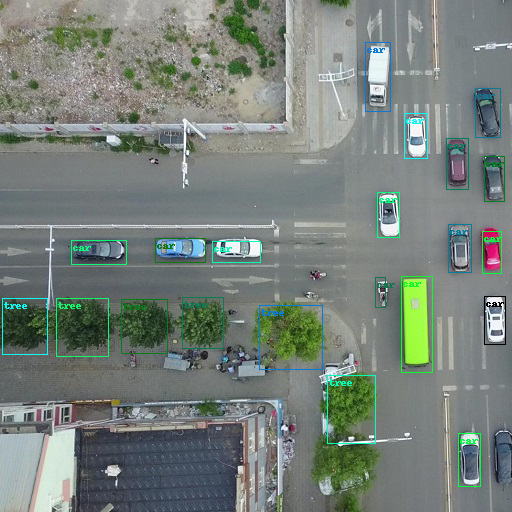

In [17]:
img, time_taken = get_inference('/content/test1.jpg', 0.7, model)
print(time_taken)
img.show()

In [ ]:
# torch.save(model.state_dict(), '/content/model_best_current.pt')
# !cp /content/model_best_current.pt /content/drive/MyDrive/Objectdetection

In [ ]:
model1 = getDroneObjectDetectionInstance()
model1.load_state_dict(torch.load('/content/model_best_current.pt'))
model1.to(device)
model1.eval()